# Trénovanie modelu iba na základe DST indexu 12 h dozadu, predikcia súčasnej hodnoty
Súbor: 12_dozadu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [1]:
!nvidia-smi

Mon Feb 27 08:40:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:8B:00.0 Off |                  N/A |
| 30%   47C    P8     1W / 125W |   4776MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')

In [4]:
train.tail()

,Unnamed: 0,time1,Rot$,IMF,PLS,IMF_PTS,PLS_PTS,ABS_B,F,THETA_AV,...,Proton_QI,DST+1,DST+2,DST+3,DST+4,DST+6,DST+8,DST+12,DST+24,DST+48
364305,364305,2004-07-21 17:00:00,2333.0,51.0,52.0,57.0,37.0,5.2,5.1,-7.5,...,0.0673,-6.0,-5.0,-4.0,-2.0,2.0,0.0,-2.0,-1.0,-6.0
364306,364306,2004-07-21 18:00:00,2333.0,51.0,52.0,59.0,36.0,5.3,5.2,-7.1,...,0.0676,-5.0,-6.0,-5.0,-4.0,1.0,1.0,-1.0,0.0,-8.0
364307,364307,2004-07-21 19:00:00,2333.0,51.0,52.0,60.0,37.0,5.5,5.5,-11.2,...,0.0683,-6.0,-5.0,-6.0,-5.0,-2.0,2.0,-2.0,1.0,-7.0
364308,364308,2004-07-21 20:00:00,2333.0,51.0,52.0,59.0,36.0,5.4,5.4,-11.3,...,0.0631,-2.0,-6.0,-5.0,-6.0,-4.0,1.0,0.0,1.0,-10.0
364309,364309,2004-07-21 21:00:00,2333.0,51.0,52.0,61.0,36.0,5.4,5.3,6.8,...,0.0597,4.0,-2.0,-6.0,-5.0,-5.0,-2.0,0.0,2.0,-11.0


In [4]:
train.columns

Index(['Unnamed: 0', 'time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS',
       'ABS_B', 'F', 'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE',
       'BY_GSM', 'BZ_GSM', 'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By',
       'SIGMA$Bz', 'T', 'N', 'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure',
       'SIGMA$T', 'SIGMA$N', 'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V',
       'SIGMA$ratio', 'E', 'Beta', 'Mach_num', 'Mgs_mach_num', 'PR$FLX_1',
       'PR$FLX_2', 'PR$FLX_4', 'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX',
       'R', 'F10_INDEX', 'KP', 'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX',
       'PC_N_INDEX', 'Solar_Lyman_alpha', 'Proton_QI', 'DST+1', 'DST+2',
       'DST+3', 'DST+4', 'DST+6', 'DST+8', 'DST+12', 'DST+24', 'DST+48'],
      dtype='object')

In [5]:
test.columns

Index(['Unnamed: 0', 'time1', 'BZ_GSM', 'F10_INDEX', 'DST', 'DST+1', 'DST+2',
       'DST+3', 'DST+4', 'DST+6', 'DST+8', 'DST+12', 'DST+24', 'DST+48'],
      dtype='object')

In [6]:
features = ['time1',
            'DST']

In [7]:
test = test[features]
train = train[features]

In [8]:
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])

In [9]:
len(train)

364310

In [10]:
len(test)

155259

In [11]:
predicted_label = 'DST'

In [12]:
train.describe()

,DST
count,364310.000000
mean,-15.985230
std,23.829845
min,-589.000000
25%,-25.000000
50%,-12.000000
75%,-1.000000
max,81.000000


In [13]:
train[predicted_label].describe()

count    364310.000000
mean        -15.985230
std          23.829845
min        -589.000000
25%         -25.000000
50%         -12.000000
75%          -1.000000
max          81.000000
Name: DST, dtype: float64

In [14]:
train.head()

,time1,DST
0,1963-01-01 01:00:00,-5.0
1,1963-01-01 02:00:00,-5.0
2,1963-01-01 03:00:00,-3.0
3,1963-01-01 04:00:00,-3.0
4,1963-01-01 05:00:00,-6.0


<AxesSubplot: >

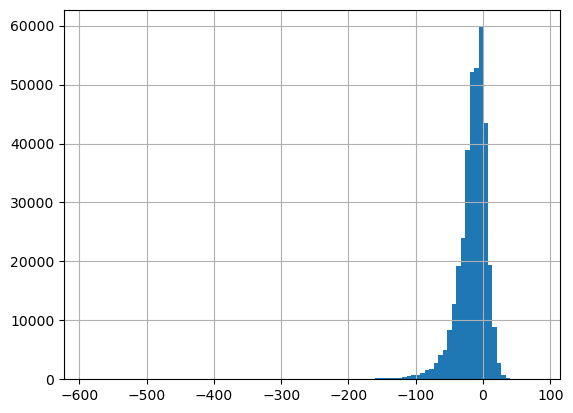

In [15]:
train[predicted_label].hist(bins=100)

In [16]:
y_col='DST'

In [17]:
# train-validation division
valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [18]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()

y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

In [19]:
print(y_test[0:40])

[ 10.  13.  16.  14.  14.  14.  11.  11.   9.   8.   7.   6.  15.  24.
  24.  22.  29.  10.  12.  11.  23.  17.  14. -20. -67. -85. -87. -90.
 -99. -91. -81. -81. -82. -79. -65. -59. -52. -52. -59. -66.]


In [20]:
len(y_test)

155259

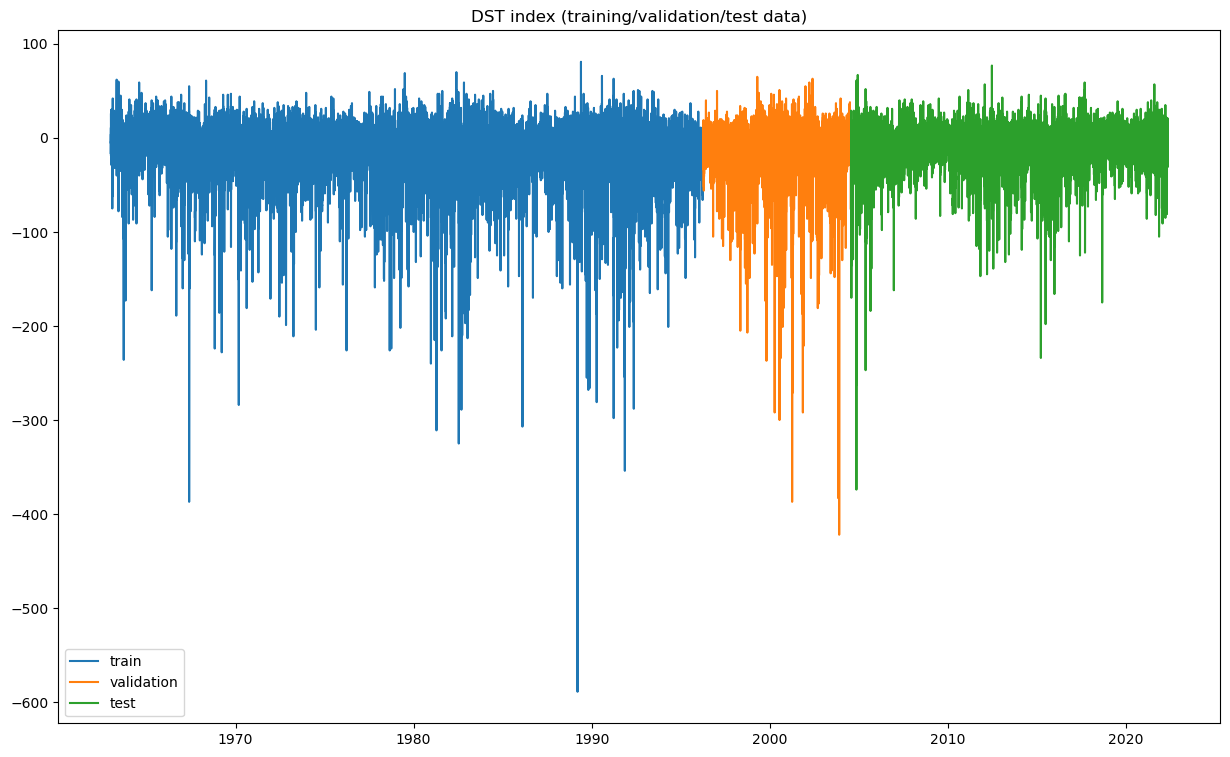

In [21]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [22]:
# set batch, n_input, n_features

n_input = 12  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [23]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

tt [[ 10.  13.  16. ...   8.   7.   6.]
 [ 13.  16.  14. ...   7.   6.  15.]
 [ 16.  14.  14. ...   6.  15.  24.]
 ...
 [-22. -24. -23. ... -25. -24. -25.]
 [-24. -23. -23. ... -24. -25. -28.]
 [-23. -23. -22. ... -25. -28. -30.]] => [  15.   24.   24.   22.   29.   10.   12.   11.   23.   17.   14.  -20.
  -67.  -85.  -87.  -90.  -99.  -91.  -81.  -81.  -82.  -79.  -65.  -59.
  -52.  -52.  -59.  -66.  -65.  -65.  -60.  -56.  -52.  -46.  -42.  -38.
  -34.  -31.  -27.  -19.  -11.  -15.  -16.   -8.   19.   15.   10.    6.
    7.    5.  -10.  -21.  -16.  -17.  -15.  -20.  -31.  -27.  -28.  -22.
  -26.  -39.  -51.  -65.  -81.  -93. -102. -102. -106. -105. -104. -102.
 -116. -126. -123. -109. -110. -126. -136. -122. -128. -130. -122. -118.
  -96.  -97.  -91.  -94.  -86.  -76.  -81.  -77.  -74.  -69.  -62.  -62.
  -57.  -54.  -53.  -52.  -54.  -55.  -49.  -48.  -49.  -52.  -49.  -42.
  -24.  -47.  -70.  -94. -102.  -66.  -64.  -92. -122. -138. -130. -121.
 -150. -148. -141. -170. -151. -145.

In [23]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  12


In [24]:
inputs = Input(shape=(n_input,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-02-27 08:41:24.121585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1901 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 12, 256)          133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           197120    
                                                                 
 time_distributed (TimeDistr  (None, 12, 1)            129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 13    

In [25]:
# callbacks
saved_model = "12_dozadu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [26]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-02-27 08:41:36.169289: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 109.8750 - mae: 5.2565
Epoch 1: val_mae improved from inf to 4.52381, saving model to 12_dozadu.hdf5
1139/1139 [==============================] - 136s 113ms/step - loss: 109.8750 - mae: 5.2565 - val_loss: 69.4095 - val_mae: 4.5238
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 46.7346 - mae: 3.9337
Epoch 2: val_mae improved from 4.52381 to 4.37170, saving model to 12_dozadu.hdf5
1139/1139 [==============================] - 128s 112ms/step - loss: 46.7346 - mae: 3.9337 - val_loss: 91.8574 - val_mae: 4.3717
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 37.4748 - mae: 3.5958
Epoch 3: val_mae improved from 4.37170 to 4.11114, saving model to 12_dozadu.hdf5
1139/1139 [==============================] - 129s 113ms/step - loss: 37.4748 - mae: 3.5958 - val_loss: 57.1456 - val_mae: 4.1111
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 36.8702 - mae: 3.5341
Epoc

In [27]:
# load best model
model = keras.models.load_model('12_dozadu.hdf5')

In [28]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 14s 21ms/step


In [29]:
y_pred

array([[  5.638379],
       [ 14.687423],
       [ 22.019127],
       ...,
       [-27.885193],
       [-20.653133],
       [-22.005993]], dtype=float32)

In [30]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[123778    849]
 [  6376  24244]]


In [31]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    124627
           1       0.97      0.79      0.87     30620

    accuracy                           0.95    155247
   macro avg       0.96      0.89      0.92    155247
weighted avg       0.95      0.95      0.95    155247



In [32]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [33]:
df

,time,y_true,y_predict
12,2004-07-22 10:00:00,15.0,5.638379
13,2004-07-22 11:00:00,24.0,14.687423
14,2004-07-22 12:00:00,24.0,22.019127
15,2004-07-22 13:00:00,22.0,18.985664
16,2004-07-22 14:00:00,29.0,17.244690
...,...,...,...
155254,2022-04-28 20:00:00,-29.0,-23.421225
155255,2022-04-28 21:00:00,-31.0,-26.352497
155256,2022-04-28 22:00:00,-25.0,-27.885193
155257,2022-04-28 23:00:00,-24.0,-20.653133


In [34]:
df.describe()

,y_true,y_predict
count,155247.000000,155247.000000
mean,-9.817910,-9.103996
std,16.341784,14.864953
min,-374.000000,-316.767426
25%,-16.000000,-14.991055
50%,-7.000000,-6.592183
75%,0.000000,-0.068966
max,77.000000,49.377491


<AxesSubplot: >

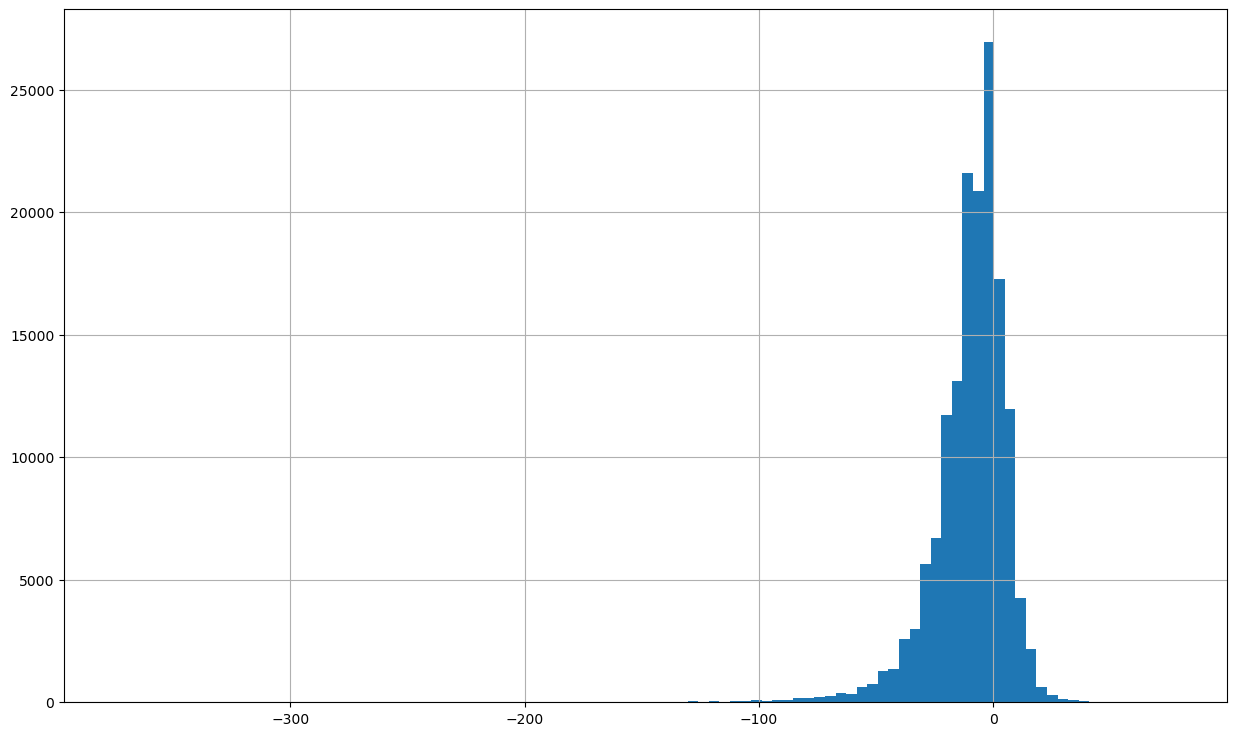

In [35]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

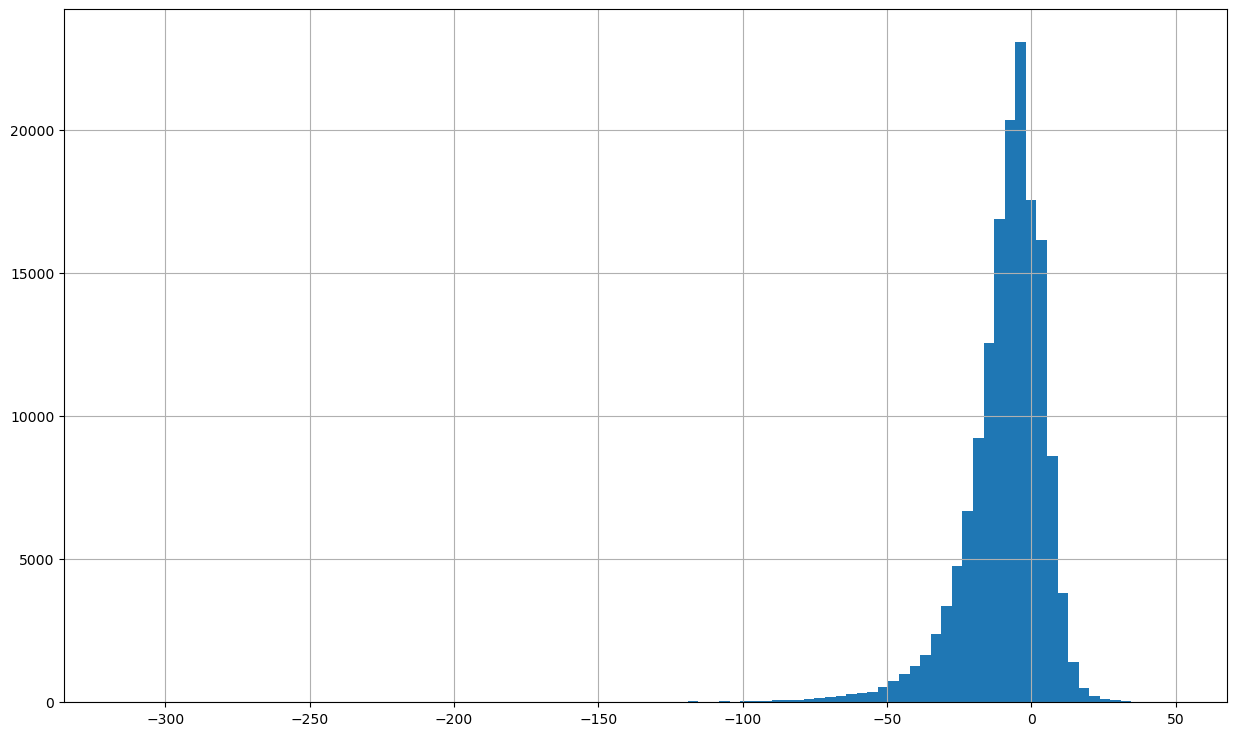

In [36]:
df["y_predict"].hist(bins=100)

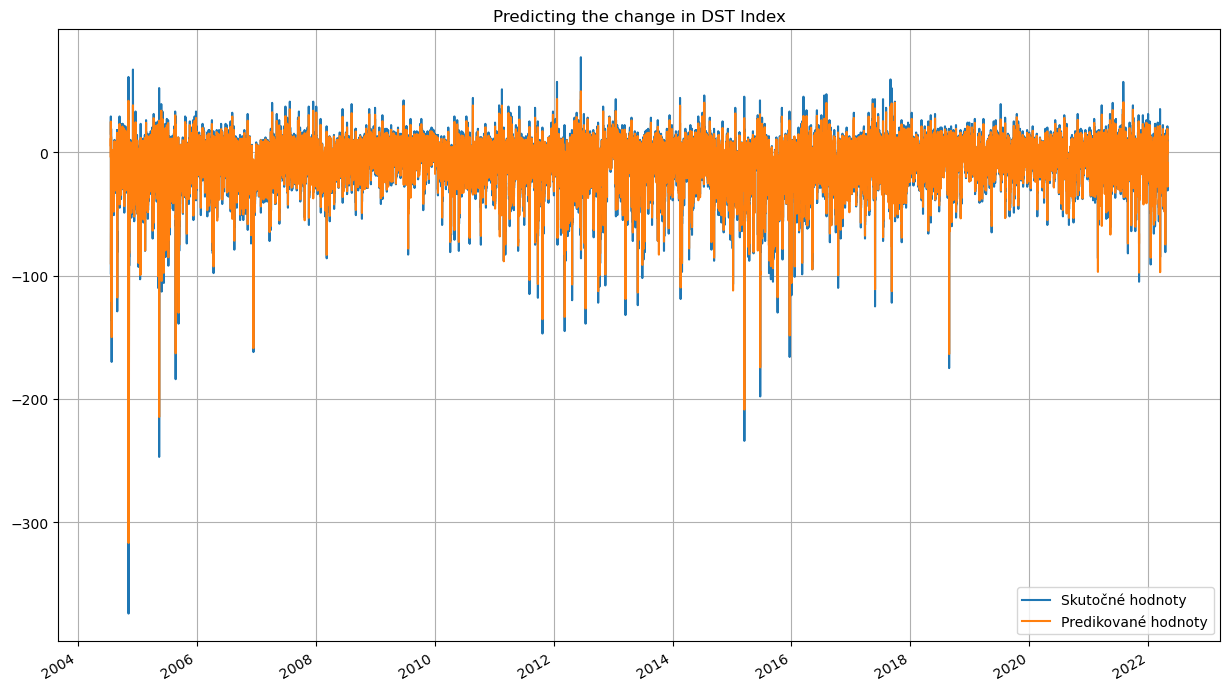

In [37]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [38]:
df.to_csv('predikcie_12h_dozadu.csv')

In [42]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

123778
849
6376
24244
TPR=0.7917700849118223
TNR=0.9931876720132876
PPV=0.9661658629896784
NPV=0.9510118782365505
FPR=0.00681232798671235
FNR=0.20822991508817768
FDR=0.033834137010321605
ACC=0.9534612585106315
MCC=0.8484961888273745
